## Loan Approval Prediction 

### Authors : 
- Mike Vogt
- Nicholas Baard
- Goolam Fareed Bangie

#### Purpose:
The aim of this project is to predict whether or not a person should be approved for a loan depending on the past information of the person

Firstly , important basic libraries need to be imported 

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,log_loss
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from scipy.special import expit
np.set_printoptions(suppress=True)
from sklearn.metrics import classification_report, confusion_matrix

The dataset for the project needs to be loaded

In [2]:
data = pd.read_csv('train_data.csv',delimiter=',')

In [3]:
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


Determine the data types each variable belongs to and if there any nulls in the variables

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


Under the non-null count column above , the count for every variable is not 614 indicating certain variables contain nulls.
Certain variables are categorical while others are numerical , one hot encoding(for variables with only 2 unique values) and label encoding(for variables with more than 2 unique values/variables with some sort of order) will be done to convert the categorical data to numerical data for ease when working with the different machine learning algorithms. 

The size of the dataset is determined below

In [5]:
print("No of rows:",data.shape[0])
print("No of columns:",data.shape[1])

No of rows: 614
No of columns: 13


Determine the number of nulls per variable

In [6]:
data.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

Nulls need to be filled in or dropped , Loan Amount, Loan_Amount_Term and Credit_History will be filled in with statistical values while the remaining nulls in the other variables will be dropped due to the fact that they are categorical and can't be filled in with statistical values. Loan Amount and Loan_Amount_Term nulls will be filled in with the current mean of Loan Amount and Loan_Amount_Term respectively while Credit_History will be filled in with its current median. 

In [7]:
mean_LoanAmount = data["LoanAmount"].mean()
data["LoanAmount"] = data["LoanAmount"].fillna(mean_LoanAmount)

mean_LoanAmount_Term = data["Loan_Amount_Term"].mean()
data["Loan_Amount_Term"] = data["Loan_Amount_Term"].fillna(mean_LoanAmount_Term)

median_Credit_History = data["Credit_History"].median()
data["Credit_History"] = data["Credit_History"].fillna(median_Credit_History)

data.dropna(inplace=True)

In [8]:
data.shape

(554, 13)

Converting Loan_Status to a numerical value

In [9]:
data["Loan_Status"].replace('N',0,inplace=True)
data["Loan_Status"].replace('Y',1,inplace=True)

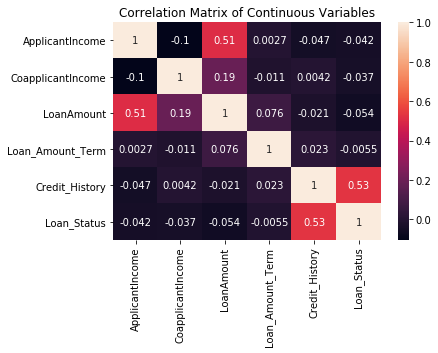

In [10]:
plt.title("Correlation Matrix of Continuous Variables")
corr = data.corr()
sns.heatmap(corr,annot=True)

It is quite clear that only Credit_History has a relationship with Loan_Status as the correlations between the other continuous variables and Loan_Status is very close to 0. For now we won't drop these columns which will allow us to compare the accuracy we get from models including these variables with models that don't contain these variables.

In [11]:
data.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status            int64
dtype: object

In [12]:
data = data.iloc[:,1:]

We remove the first column from the dataframe as it is just an index for the observations and will not be used in the respective machine learning algorithms.

In [13]:
from sklearn.preprocessing import LabelEncoder 
LE = LabelEncoder()

In [14]:
data["Property_Area"] = LE.fit_transform(data["Property_Area"])

data["Dependents"] = LE.fit_transform(data["Dependents"])

data = pd.get_dummies(data)

data.head()

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Gender_Female,Gender_Male,Married_No,Married_Yes,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes
0,0,5849,0.0,146.412162,360.0,1.0,2,1,0,1,1,0,1,0,1,0
1,1,4583,1508.0,128.000000,360.0,1.0,0,0,0,1,0,1,1,0,1,0
2,0,3000,0.0,66.000000,360.0,1.0,2,1,0,1,0,1,1,0,0,1
3,0,2583,2358.0,120.000000,360.0,1.0,2,1,0,1,0,1,0,1,1,0
4,0,6000,0.0,141.000000,360.0,1.0,2,1,0,1,1,0,1,0,1,0


In [15]:
data = data.sample(frac=1,random_state=10).reset_index(drop=True)

Y = data["Loan_Status"]
X = data.drop("Loan_Status",1)

We first make sure every variable is numerical before the training and so we perform label encoding on the Propert_Area and Dependents variables.
Now that every variable is numerical , training and testing datasets can be specified from this original dataset. We shuffle the data as it helps the training converge fast, prevents any bias during the training and prevents the model from learning the order of the training.

In [16]:
train_number = int(data.shape[0]*(80/100)) # calculate number of training examples
train_data = X.iloc[0:train_number,0:15] # split data into training data using the number calculated above
train_y = Y.iloc[0:train_number] # split target values into training target values
train_y = train_y.astype('int32') # convert labels to integer 
test_data = X.iloc[train_number:,0:15] # get test data from full data 
test_y = Y.iloc[train_number:] # get test target values from full dat
test_y = test_y.astype('int32') # convert labels to integer
display(train_data.head())
print(train_y.shape)
print(test_data.shape)
print(test_y.shape)

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Gender_Female,Gender_Male,Married_No,Married_Yes,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes
0,0,18165,0.000000,125.0,360.0,1.0,2,1,0,1,0,0,1,0,1
1,2,5935,0.000000,133.0,360.0,1.0,1,0,1,0,1,1,0,1,0
2,2,3427,0.000000,138.0,360.0,1.0,2,1,0,1,0,1,0,1,0
3,0,2920,16.120001,87.0,360.0,1.0,0,0,1,0,1,1,0,1,0
4,2,3859,0.000000,96.0,360.0,1.0,1,0,1,0,1,1,0,1,0


(443,)
(111, 15)
(111,)


### Logistic Regression Classifier

We first reload the dataframe as there will be different changes that need to be made in order for the data to fit the Linear Regression Model

In [17]:
data_LR = pd.read_csv('train_data.csv',index_col="Loan_ID")
data_LR.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
Loan_ID,,,,,,,,,,,,
LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


We use dummy encoding in the following cell to make all categorical variables numeric.

In [18]:
data_LR['Gender'].replace('Male',1,inplace=True)
data_LR['Gender'].replace('Female',0,inplace=True)

data_LR['Married'].replace('Yes',1,inplace=True)
data_LR['Married'].replace('No',0,inplace=True)

data_LR['Dependents'].replace('3+',3,inplace=True)
#df['Dependents'].astype('int32')

data_LR['Education'].replace('Graduate',1,inplace=True)
data_LR['Education'].replace('Not Graduate',0,inplace=True)

data_LR['Self_Employed'].replace('Yes',1,inplace=True)
data_LR['Self_Employed'].replace('No',0,inplace=True)

data_LR['Property_Area'].replace('Urban',2,inplace=True)
data_LR['Property_Area'].replace('Semiurban',1,inplace=True)
data_LR['Property_Area'].replace('Rural',0,inplace=True)

data_LR['Loan_Status'].replace('Y',1,inplace=True)
data_LR['Loan_Status'].replace('N',0,inplace=True)

In [19]:
data_LR.isnull().sum()

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

After analysing the amount of missing data, we use the same methods to fill the missing values of the numerical data and then drop remaining rows that contain NaN values that cannot be replaced with mean/median.

In [20]:
mean_LoanAmount = data_LR["LoanAmount"].mean()
data_LR["LoanAmount"] = data_LR["LoanAmount"].fillna(mean_LoanAmount)

mean_LoanAmount_Term = data_LR["Loan_Amount_Term"].mean()
data_LR["Loan_Amount_Term"] = data_LR["Loan_Amount_Term"].fillna(mean_LoanAmount_Term)

median_Credit_History = data_LR["Credit_History"].median()
data_LR["Credit_History"] = data_LR["Credit_History"].fillna(median_Credit_History)

data_LR['Dependents'] = pd.to_numeric(data_LR['Dependents'])
data_LR.dropna(inplace=True)
data_LR.shape

(554, 12)

We then shuffle the array and create training, testing and validation datasets with a 60%/20%/20% split, respectively.

In [21]:
#Shuffle Array
def shuffleSplit(data_NN):
    df_shuffle = data_NN.copy()
    df_shuffle = df_shuffle.sample(frac=1).reset_index(drop=True)
    
    #Split into training/testing/validating (60%/20%/20%)
    df_train = df_shuffle.loc[:.6*len(data_NN)]
    df_test = df_shuffle.loc[.6*len(data_NN)+1:.8*len(data_NN)].reset_index(drop=True)
    df_validate = df_shuffle.loc[.8*len(data_NN)+1:].reset_index(drop=True)

    #Remove classification bias in training data
    df_0 = df_train.loc[df_train['Loan_Status']==0]
    df_1 = df_train.loc[df_train['Loan_Status']==1]

    x_train = df_train.drop(["Loan_Status"], axis = 1)
    y_train = df_train["Loan_Status"]

    x_test = df_test.drop(["Loan_Status"], axis = 1)
    y_test = df_test["Loan_Status"].reset_index(drop=True)

    x_validate = df_validate.drop(["Loan_Status"], axis = 1)
    y_validate = df_validate["Loan_Status"].reset_index(drop=True)
    
    return x_train, x_test, y_train, y_test, x_validate, y_validate


x_train, x_test, y_train, y_test, x_validate, y_validate = shuffleSplit(data_LR)


We fit the Logistic Regression Model on the training dataset and make predictions on the test dataset. The results of the prediction are compared to the actual labels of the test data set and are shown in a confusion matrix along with a final testing accuracy.



-------- Results From Predicting --------


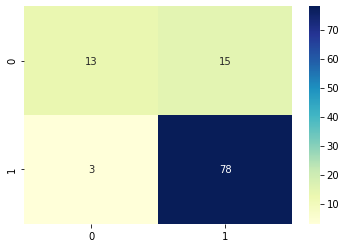





Accuracy:  83.4862385321101 %


              precision    recall  f1-score   support

           0       0.81      0.46      0.59        28
           1       0.84      0.96      0.90        81

    accuracy                           0.83       109
   macro avg       0.83      0.71      0.74       109
weighted avg       0.83      0.83      0.82       109



In [22]:
LR = LogisticRegression(penalty='none', max_iter = 500)
LR.fit(x_train, y_train)
predictions = LR.predict(x_validate)
pred_series = pd.Series(predictions)
print("\n")
#Plot results on confusion matrix
print("-------- Results From Predicting --------")
#confusion_matrix = pd.crosstab(y_validate, pred_series, rownames=['Actual'], colnames = ['Predicted'])
cf_matrix = confusion_matrix(y_validate, predictions)

sns.heatmap(cf_matrix, annot=True,cmap="YlGnBu")
plt.show()
print("\n")
#display(confusion_matrix)
print("\n")
accuracy = LR.score(x_validate, y_validate)
print("Accuracy: ",accuracy*100,'%')
print("\n")
print(classification_report(y_validate, predictions))

#### Improved Learning

##### Normalising the dataframe
We normalise the columns of the dataframe in order to reduce bias in our model. This is because some variables are represented as 1's and 0's in the form of dummy encoding for categorical data and some numerical variables are represented as dollar values for incomes and loan amounts. 

In [23]:
data_LR_Norm = data_LR.copy()
index = data_LR_Norm.columns.drop(['Loan_Status'])
#print(index)
for i in range(data_LR_Norm.shape[1]-1):
    data_LR_Norm[index[i]] = (data_LR_Norm[index[i]]-data_LR_Norm[index[i]].mean())/data_LR_Norm[index[i]].std()
    
data_LR_Norm.describe()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
count,5.540000e+02,5.540000e+02,5.540000e+02,5.540000e+02,5.540000e+02,5.540000e+02,5.540000e+02,5.540000e+02,5.540000e+02,5.540000e+02,5.540000e+02,554.000000
mean,-5.691396e-17,-1.723451e-17,3.102212e-16,2.148302e-16,3.206420e-17,-1.928862e-17,5.130272e-17,5.545604e-16,-1.376757e-16,3.086180e-16,6.509409e-16,0.689531
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.463104
min,-2.115905e+00,-1.371865e+00,-7.517676e-01,-1.870225e+00,-3.983828e-01,-9.380213e-01,-6.280789e-01,-1.677006e+00,-5.097615e+00,-2.431934e+00,-1.309702e+00,0.000000
25%,4.717580e-01,-1.371865e+00,-7.517676e-01,5.337300e-01,-3.983828e-01,-4.442231e-01,-6.280789e-01,-5.546360e-01,2.787575e-01,4.104531e-01,-1.309702e+00,0.000000
50%,4.717580e-01,7.276190e-01,-7.517676e-01,5.337300e-01,-3.983828e-01,-2.616896e-01,-1.729365e-01,-2.092913e-01,2.787575e-01,4.104531e-01,-3.899287e-02,1.000000
75%,4.717580e-01,7.276190e-01,1.226756e+00,5.337300e-01,-3.983828e-01,1.011318e-01,2.819087e-01,2.686411e-01,2.787575e-01,4.104531e-01,1.231716e+00,1.000000
max,4.717580e-01,7.276190e-01,2.216018e+00,5.337300e-01,2.505618e+00,1.388280e+01,1.277545e+01,6.228920e+00,2.132679e+00,4.104531e-01,1.231716e+00,1.000000


We reshuffle and divide the normalised data into train, validation and testing datasets.

In [24]:
x_train, x_test, y_train, y_test, x_validate, y_validate = shuffleSplit(data_LR_Norm)

We refit the Logistic Regression model with L2 regularization to the normalised training set and make predictions on the normalised testing set. The results are shown in a confusion matrix.



-------- Results From Predicting --------


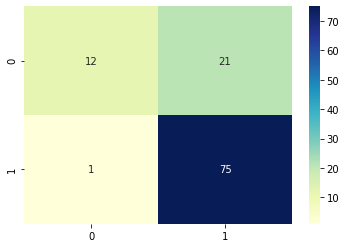



79.81651376146789 %


              precision    recall  f1-score   support

           0       0.92      0.36      0.52        33
           1       0.78      0.99      0.87        76

    accuracy                           0.80       109
   macro avg       0.85      0.68      0.70       109
weighted avg       0.82      0.80      0.77       109



In [25]:
LR = LogisticRegression(penalty='l2', max_iter = 500)
LR.fit(x_train, y_train)
predictions = LR.predict(x_validate)
pred_series = pd.Series(predictions)
print("\n")
#Plot results on confusion matrix
print("-------- Results From Predicting --------")
cf_matrix = confusion_matrix(y_validate, predictions)
sns.heatmap(cf_matrix, annot=True,cmap="YlGnBu")
plt.show()
print("\n")
accuracy = LR.score(x_validate, y_validate)
print(accuracy*100,'%')
print("\n")
print(classification_report(y_validate, predictions))

Now that we have our best model, we predict on the testing dataset to achieve a final accuracy of the model.



-------- Results From Predicting --------


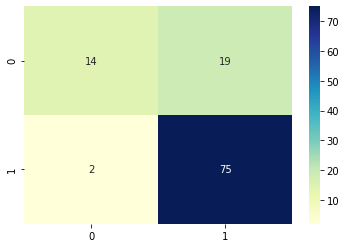



80.9090909090909 %


              precision    recall  f1-score   support

           0       0.88      0.42      0.57        33
           1       0.80      0.97      0.88        77

    accuracy                           0.81       110
   macro avg       0.84      0.70      0.72       110
weighted avg       0.82      0.81      0.79       110



In [26]:
predictions = LR.predict(x_test)
pred_series = pd.Series(predictions)
print("\n")
#Plot results on confusion matrix
print("-------- Results From Predicting --------")
cf_matrix = confusion_matrix(y_test, predictions)
sns.heatmap(cf_matrix, annot=True,cmap="YlGnBu")
plt.show()
print("\n")
accuracy = LR.score(x_test, y_test)
print(accuracy*100,'%')
print("\n")
print(classification_report(y_test, predictions))

### Neural Networks Classifier

We use the same version of the dataset that we did in Logistic Regression as all categrical variables are represented as dummy variables. This is required as a Neural Network can only work with numerical data.

In [27]:
data_NN = data_LR.copy()

We divide the data into training, validation and testing datasets using a 60%/20%/20% split, respectively.

In [28]:
x_train, x_test, y_train, y_test, x_validate, y_validate = shuffleSplit(data_NN)

Below are the activation fauncions used as well as their derivatives. The type of activation function used will be explored in model fitting and their effectiveness will be determined on the validation dataset.

There is also the feedforward function which trains the neural network with backpropagation as well as a predict function that uses the trained weights to predict an output on the validation or testing dataset.

In [29]:
# Activation functions

def ReLU(x):
    return np.maximum(0, x)

def sigmoid(x):
    return 1/(1 + np.exp(-x))

def linear(x):
    return x

def tanh(x):
    return 2/(1 + np.exp(-2*x)) - 1

def dif_ReLU(x):
    if(x >= 0):
        return 1
    else:
        return 0
    
def dif_sigmoid(x):
    return sigmoid(x)*(1 - sigmoid(x))

def dif_linear(x):
    return 1

def dif_tanh(x):
    return 1/(np.square(x) + 1)

def feed_forward(x, hidden, y, alpha, epoch, lmda, act, dif_act):
    error_total = []
    
    np.random.seed(10)
    
    w1 = np.random.randn(hidden, len(x.columns))/np.sqrt(len(x.columns))
    bias1 = np.random.randn(hidden,1)
    
    w2 = np.random.randn(1, hidden)/np.sqrt(hidden)
    bias2 = np.random.randn(1,1)
    mse_old = 100000
    diff = 100000
    ind = 0
    while(diff > 0.00001 and ind < epoch):
        z_arr = []

        for i in range(len(x)):

            a1 = x.iloc[i].values.reshape((len(x.columns),1))

            z2 = np.dot(w1, a1) + bias1
            a2 = act(z2)

            z3 = np.dot(w2, a2) + bias2
            a3 = sigmoid(z3)


            z_arr.append(float(a3))

            yhat = a3

            ### BACKPROPAGATION ###

            d3 = yhat - y.iloc[i]
            d2 = np.dot(w2.T, d3)*dif_sigmoid(z3)

            J1 = np.dot(d2,a1.reshape((1,len(x.columns)))) + lmda*np.sum(np.square(w1))  #L1 = np.sum(np.abs(w1)), L2 = np.sum(np.square(w1))
            J2 = np.dot(d3,a2.reshape((1,hidden))) + lmda*np.sum(np.square(w2))
            
            w1 -= alpha*J1 
            w2 -= alpha*J2 
            
        yhat_total = np.array(z_arr)
        
        mse = 1/len(x)*np.sum(np.square(yhat_total - y))
        acc = (1-mse)
        diff = mse_old - mse
        mse_old = mse
        #print(diff)
        ind +=1
        #print(ind)
        error_total.append(mse)
        
        
        
    return error_total, w1, w2
    
def predict(x, hidden, w1, w2, act, boundary):
    np.random.seed(10)
    bias1 = np.random.randn(hidden,1)
    bias2 = np.random.randn(1,1)
    predictions = []
    for i in range(len(x)): #len(x)

            a1 = x.iloc[i].values.reshape((len(x.columns),1))
            z2 = np.dot(w1, a1) + bias1
            a2 = act(z2)

            z3 = np.dot(w2, a2) + bias2
            a3 = sigmoid(z3)

            yhat = a3
            #print(yhat)
            if(yhat < boundary):
                predictions.append(0)
            else:
                predictions.append(1)
                
    return predictions     
    

We set the hyperparameters and train the neural network. We make predictions on the validating set and adjust the hyperparameters to obtain the best results. 

The prediction error during training is displayed over time in a line graph to show that the error converges during training.

The results from the prediction are displayed in a confusion matrix.

-------- Results From Training --------


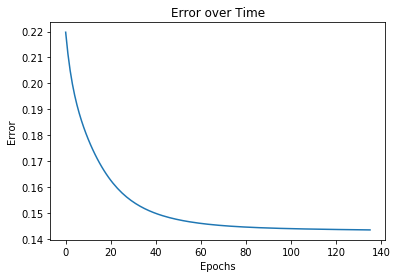

Final Training Error:  14.357241419755043 %


-------- Results From Predicting --------


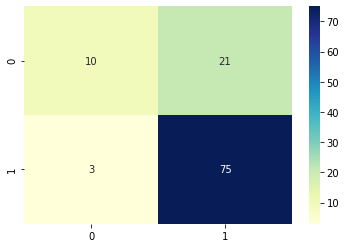



              precision    recall  f1-score   support

           0       0.77      0.32      0.45        31
           1       0.78      0.96      0.86        78

    accuracy                           0.78       109
   macro avg       0.78      0.64      0.66       109
weighted avg       0.78      0.78      0.75       109



In [34]:
#hyperparameters:
hidden = 9 # 9 = best
alpha = 0.001 # 0.0001 = best for Normalised data
lamda = 0.0 # = 0.001 = best for L2 regularization

#activation function:
activation = tanh
dif_activation = dif_tanh
boundary = 0.5

#Train neural network:
error, theta1, theta2 = feed_forward(x_train, hidden, y_train, alpha, 2000, lamda, activation, dif_activation)

#Plot error
print("-------- Results From Training --------")
plt.plot(np.arange(0,len(error)),error)
plt.title("Error over Time")
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()  
print("Final Training Error: ", error[-1]*100,"%")

#Predict on the validation set
predictions = predict(x_validate, hidden, theta1, theta2, activation, boundary)
pred_series = pd.Series(predictions)
print("\n")
#Plot results on confusion matrix
print("-------- Results From Predicting --------")
cf_matrix = confusion_matrix(y_validate, predictions)

sns.heatmap(cf_matrix, annot=True,cmap="YlGnBu")
plt.show()
print("\n")
print(classification_report(y_validate, predictions))

#### Improved Learning
##### Normalising the dataset

Before making predictions on the test dataset, we try to improve the learning of the model so that we can obtain a higher testing accuracy. We normalise the data so that there is no bias in our variables.

In [35]:
data_NN_Norm = data_NN.copy()
index = data_NN_Norm.columns.drop(['Loan_Status'])
#print(index)
for i in range(data_NN_Norm.shape[1]-1):
    data_NN_Norm[index[i]] = (data_NN_Norm[index[i]]-data_NN_Norm[index[i]].mean())/data_NN_Norm[index[i]].std()
    
data_NN_Norm.describe()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
count,5.540000e+02,5.540000e+02,5.540000e+02,5.540000e+02,5.540000e+02,5.540000e+02,5.540000e+02,5.540000e+02,5.540000e+02,5.540000e+02,5.540000e+02,554.000000
mean,-5.691396e-17,-1.723451e-17,3.102212e-16,2.148302e-16,3.206420e-17,-1.928862e-17,5.130272e-17,5.545604e-16,-1.376757e-16,3.086180e-16,6.509409e-16,0.689531
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.463104
min,-2.115905e+00,-1.371865e+00,-7.517676e-01,-1.870225e+00,-3.983828e-01,-9.380213e-01,-6.280789e-01,-1.677006e+00,-5.097615e+00,-2.431934e+00,-1.309702e+00,0.000000
25%,4.717580e-01,-1.371865e+00,-7.517676e-01,5.337300e-01,-3.983828e-01,-4.442231e-01,-6.280789e-01,-5.546360e-01,2.787575e-01,4.104531e-01,-1.309702e+00,0.000000
50%,4.717580e-01,7.276190e-01,-7.517676e-01,5.337300e-01,-3.983828e-01,-2.616896e-01,-1.729365e-01,-2.092913e-01,2.787575e-01,4.104531e-01,-3.899287e-02,1.000000
75%,4.717580e-01,7.276190e-01,1.226756e+00,5.337300e-01,-3.983828e-01,1.011318e-01,2.819087e-01,2.686411e-01,2.787575e-01,4.104531e-01,1.231716e+00,1.000000
max,4.717580e-01,7.276190e-01,2.216018e+00,5.337300e-01,2.505618e+00,1.388280e+01,1.277545e+01,6.228920e+00,2.132679e+00,4.104531e-01,1.231716e+00,1.000000


We divide the data into training, validation and testing datasets using a 60%/20%/20% split, respectively.

In [36]:
x_train, x_test, y_train, y_test, x_validate, y_validate = shuffleSplit(data_NN_Norm)

We retrain the model the same way as before with the normalised data and make predictions on the validataion dataset. We adjust the hyperparameters to try obtain the highest validation accuracy.

-------- Results From Training --------


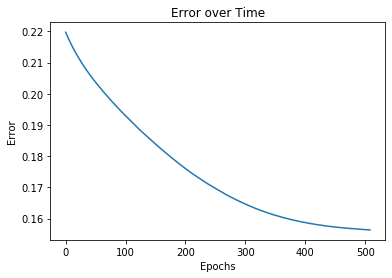

Final Training Error:  15.635454900095844 %


-------- Results From Predicting --------


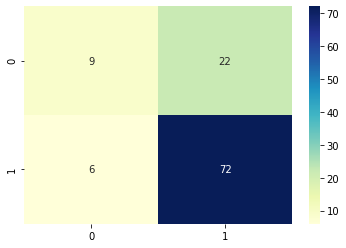



              precision    recall  f1-score   support

           0       0.60      0.29      0.39        31
           1       0.77      0.92      0.84        78

    accuracy                           0.74       109
   macro avg       0.68      0.61      0.61       109
weighted avg       0.72      0.74      0.71       109



In [38]:
#hyperparameters:
hidden = 9 # 9 = best
alpha = 0.0001 # 0.0001 = best for Normalised data
lamda = 0.001 # = 0.001 = best for L2 regularization

#activation function:
activation = ReLU
dif_activation = dif_ReLU
boundary = 0.5

#Train neural network:
error, theta1, theta2 = feed_forward(x_train, hidden, y_train, alpha, 2000, lamda, activation, dif_activation)

#Plot error
print("-------- Results From Training --------")
plt.plot(np.arange(0,len(error)),error)
plt.title("Error over Time")
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()  
print("Final Training Error: ", error[-1]*100,"%")

#Predict on the validation set
predictions = predict(x_validate, hidden, theta1, theta2, activation, boundary)
pred_series = pd.Series(predictions)
print("\n")
#Plot results on confusion matrix
print("-------- Results From Predicting --------")
cf_matrix = confusion_matrix(y_validate, predictions)

sns.heatmap(cf_matrix, annot=True,cmap="YlGnBu")
plt.show()
print("\n")
print(classification_report(y_validate, predictions))

Once we have achived our best model, we predict using our testing data to immitate unseen data and achieve a final testing accuracy.



-------- Results From Predicting --------


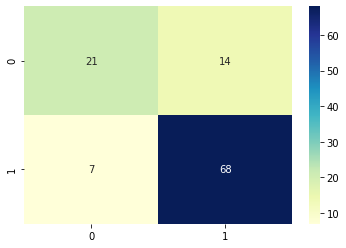



              precision    recall  f1-score   support

           0       0.75      0.60      0.67        35
           1       0.83      0.91      0.87        75

    accuracy                           0.81       110
   macro avg       0.79      0.75      0.77       110
weighted avg       0.80      0.81      0.80       110



In [39]:
predictions = predict(x_test, hidden, theta1, theta2, activation, boundary)
pred_series = pd.Series(predictions)
print("\n")
#Plot results on confusion matrix
print("-------- Results From Predicting --------")
cf_matrix = confusion_matrix(y_test, predictions)
sns.heatmap(cf_matrix, annot=True,cmap="YlGnBu")
plt.show()
print("\n")
print(classification_report(y_test, predictions))

### Decision Tree Classifier

Firstly , the decision tree classifier is built using sklearn 

In [ ]:
loan_tree_classifier = DecisionTreeClassifier()
loan_tree_classifier.fit(train_data,train_y)

We then use our trained classifier to make predictions on our test data and store it in a variable called predicted_values

In [ ]:
predicted_values = loan_tree_classifier.predict(test_data)

The accuracy of the prediction is then calculated. In this case the accuracy is quite low and thats due to the fact that our classifier contains variables that have very little correlation to the class label variable , we can improve accuracy by removing these variables or we can use improvement techniques such as using multiple trees instead of a single decision tree also known as a random forest.

In [ ]:
accuracy_score(test_y,predicted_values)*100

From the above accuracy we can evaluate that our simple decision trees model is not the best but it is decently accurate. We will try to improve this accuracy in the improved learning section.

In [ ]:
log_loss(test_y,predicted_values)

Here we calculate the loss above and see that the overall log loss of the model is quite high

Display the confusion matrix of the classification of the test data , diagonal elements represent the number of correct classifications whereas other elements represent the number of incorrect classifications.

In [ ]:
cf_matrix = confusion_matrix(predicted_values, test_y)
# heatmap of confusion matrix for model
sns.heatmap(cf_matrix, annot=True,fmt='g')

### Improved Learning for Decision Trees

#### Remove uncorrelated variables 

Certain variables weren't correlated with loan status and so in order to improve accuracy of our model we will remove these uncorrelated variables.

In [ ]:
imp_train_data = train_data.copy()
imp_train_data = imp_train_data.drop(labels=['ApplicantIncome'],axis=1)
imp_train_data = imp_train_data.drop(labels=['CoapplicantIncome'],axis=1)
imp_train_data = imp_train_data.drop(labels=['LoanAmount'],axis=1)
imp_train_data = imp_train_data.drop(labels=['Loan_Amount_Term'],axis=1)

imp_test_data = test_data.copy()
imp_test_data = imp_test_data.drop(labels=['ApplicantIncome'],axis=1)
imp_test_data = imp_test_data.drop(labels=['CoapplicantIncome'],axis=1)
imp_test_data = imp_test_data.drop(labels=['LoanAmount'],axis=1)
imp_test_data = imp_test_data.drop(labels=['Loan_Amount_Term'],axis=1)

In [ ]:
display(imp_train_data)

As we can see above that the uncorrelated variables are removed from the model.

In [ ]:
loan_tree_classifier = DecisionTreeClassifier()
loan_tree_classifier.fit(imp_train_data,train_y)

In [ ]:
predicted_values_imp = loan_tree_classifier.predict(imp_test_data)

In [ ]:
accuracy_score(test_y,predicted_values_imp)*100

In [ ]:
log_loss(test_y,predicted_values_imp)

In [ ]:
cf_matrix = confusion_matrix(predicted_values_imp, test_y)
# heatmap of confusion matrix for model
sns.heatmap(cf_matrix, annot=True,fmt='g')

Much improved results are seen once the uncorrelated variables are removed.

Lets investigate if we can improve the results even further with the help of the Random Forest classifer.
A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is controlled with the max_samples parameter if bootstrap=True (default), otherwise the whole dataset is used to build each tree.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
random_forest = RandomForestClassifier(n_estimators=26)
random_forest.fit(imp_train_data,train_y)

n_estimators is the number of trees you want to build before taking the maximum voting or averages of predictions. Higher number of trees give us better performance but makes our code slower. When we set this value to 26 it was the perfect balance between performance and cost. Cost here refers to the computational workload on our computers.

In [ ]:
predicted_values_rf = random_forest.predict(imp_test_data)

In [ ]:
accuracy_score(test_y,predicted_values_rf)*100

In [ ]:
log_loss(test_y,predicted_values_rf)

In [ ]:
cf_matrix = confusion_matrix(predicted_values_rf, test_y)
# heatmap of confusion matrix for model
sns.heatmap(cf_matrix, annot=True,fmt='g')

Random Forest was used to improve the accuracy slightly from our above improved learning algorithm and leaves us with a final accuracy of between 81% and 86% accuracy which is pretty good. 

## K-Nearest Neighbours

In [ ]:
Y = data_LR["Loan_Status"]
X = data_LR.drop("Loan_Status",1)
data_LR.head()

In [ ]:
print(x_train.shape)
print(len(x_train.columns))
print(x_train.columns)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

The method used below to obtain the results is: shuffle data, make train-test split, create K-Nearest Neighbours classifier using the sklearn library and use a for-loop to find its optimal k-value, and make predictions. This is performed 20 times to find the average max, and minimum of the dataset

In [ ]:
k_arr = np.array([])
big_acc_arr = np.array([])
ll = np.array([])
for i in range(20):
    x_train, x_test, y_train, y_test = shuffleSplit(data_NN)
    accuracy = np.array([])
    for k in range(1,30):
        classifier = KNeighborsClassifier(n_neighbors=k)
        classifier.fit(x_train, y_train)
        y_pred = classifier.predict(x_test)
        acc = accuracy_score(y_test,y_pred)*100
        accuracy =  np.append(accuracy, acc)
        
    
    #print(np.argmax(accuracy))
   # print(accuracy)
    k_arr = np.append(k_arr, np.argmax(accuracy)+1)
    knn_classifier = KNeighborsClassifier(n_neighbors=np.argmax(accuracy)+1)
    knn_classifier.fit(x_train, y_train)
    y_pred = knn_classifier.predict(x_test)
    big_acc = accuracy_score(y_test,y_pred)*100
    big_acc_arr = np.append(big_acc_arr, big_acc)
    lloss = log_loss(y_test,y_pred)
    ll = np.append(lloss, ll)

In [ ]:
k_arr = pd.Series(k_arr).astype('int')
big_acc_arr = pd.Series(big_acc_arr)
ll = pd.Series(ll)
df_initKNN = pd.concat([ k_arr, big_acc_arr, ll], axis=1)
df_initKNN.columns = ["K Neighbours", "Accuracy", "Log Loss"]
display(df_initKNN)

big_max = pd.Series(big_acc_arr.max())
big_min = pd.Series(big_acc_arr.min())
big_mean = pd.Series(big_acc_arr.mean())
big_loss = pd.Series(ll.mean())

df_initStats = pd.concat([big_max, big_min, big_mean, big_loss], axis=0)
df_initStats.columns = ["Accuracy Summary Statistics"]
df_initStats.index = ["max", "min", "mean", "mean log loss"]
print("\n")
display(df_initStats)

In [ ]:
cf_matrix = confusion_matrix(y_pred, y_test)
sns.heatmap(cf_matrix, annot=True,fmt='g')

Due to the difficulty of calculating distance between data with a large number of features, as well as distances between categorical features, the categorical features are removed, thus also reducing the number of dimensions

In [ ]:
df_drop = data_NN[["Loan_Status", "ApplicantIncome", "CoapplicantIncome", "LoanAmount", "Loan_Amount_Term"]].copy()
df_drop.head()

In [ ]:
k_arr = np.array([])
big_acc_arr = np.array([])
ll = np.array([])
for i in range(20):
    x_train, x_test, y_train, y_test = shuffleSplit(df_drop)
    accuracy = np.array([])
    for k in range(1,30):
        classifier = KNeighborsClassifier(n_neighbors=k)
        classifier.fit(x_train, y_train)
        y_pred = classifier.predict(x_test)
        acc = accuracy_score(y_test,y_pred)*100
        accuracy =  np.append(accuracy, acc)
        
    
    #print(np.argmax(accuracy))
   # print(accuracy)
    k_arr = np.append(k_arr, np.argmax(accuracy)+1)
    knn_classifier = KNeighborsClassifier(n_neighbors=np.argmax(accuracy)+1)
    knn_classifier.fit(x_train, y_train)
    y_pred = knn_classifier.predict(x_test)
    big_acc = accuracy_score(y_test,y_pred)*100
    big_acc_arr = np.append(big_acc_arr, big_acc)
    lloss = log_loss(y_test,y_pred)
    ll = np.append(lloss, ll)

In [ ]:
k_arr = pd.Series(k_arr).astype('int')
big_acc_arr = pd.Series(big_acc_arr)
ll = pd.Series(ll)
df_initKNN = pd.concat([ k_arr, big_acc_arr, ll], axis=1)
df_initKNN.columns = ["K Neighbours", "Accuracy", "Log Loss"]
display(df_initKNN)

big_max = pd.Series(big_acc_arr.max())
big_min = pd.Series(big_acc_arr.min())
big_mean = pd.Series(big_acc_arr.mean())
big_loss = pd.Series(ll.mean())

df_initStats = pd.concat([big_max, big_min, big_mean, big_loss], axis=0)
df_initStats.columns = ["Accuracy Summary Statistics"]
df_initStats.index = ["max", "min", "mean", "mean log loss"]
print("\n")
display(df_initStats)

In [ ]:
cf_matrix = confusion_matrix(y_pred, y_test)
sns.heatmap(cf_matrix, annot=True,fmt='g')

Perform feature scaling to try increase the prediction accuracy

In [ ]:
from sklearn.preprocessing import MinMaxScaler
def scaler(x_train, x_test):
    norm = MinMaxScaler().fit(x_train)
    x_train_stand = norm.transform(x_train)
    x_test_stand = norm.transform(x_test)
    return x_train_stand, x_test_stand

In [ ]:
k_arr = np.array([])
big_acc_arr = np.array([])
ll = np.array([])
for i in range(20):
    x_train, x_test, y_train, y_test = shuffleSplit(data_NN)
    x_train , x_test = scaler(x_train, x_test)
    accuracy = np.array([])
    for k in range(1,30):
        classifier = KNeighborsClassifier(n_neighbors=k)
        classifier.fit(x_train, y_train)
        y_pred = classifier.predict(x_test)
        acc = accuracy_score(y_test,y_pred)*100
        accuracy =  np.append(accuracy, acc)
        
    
    #print(np.argmax(accuracy))
   # print(accuracy)
    k_arr = np.append(k_arr, np.argmax(accuracy)+1)
    knn_classifier = KNeighborsClassifier(n_neighbors=np.argmax(accuracy)+1)
    knn_classifier.fit(x_train, y_train)
    y_pred = knn_classifier.predict(x_test)
    big_acc = accuracy_score(y_test,y_pred)*100
    big_acc_arr = np.append(big_acc_arr, big_acc)
    lloss = log_loss(y_test,y_pred)
    ll = np.append(lloss, ll)

In [ ]:
k_arr = pd.Series(k_arr).astype('int')
big_acc_arr = pd.Series(big_acc_arr)
ll = pd.Series(ll)
df_initKNN = pd.concat([ k_arr, big_acc_arr, ll], axis=1)
df_initKNN.columns = ["K Neighbours", "Accuracy", "Log Loss"]
display(df_initKNN)

big_max = pd.Series(big_acc_arr.max())
big_min = pd.Series(big_acc_arr.min())
big_mean = pd.Series(big_acc_arr.mean())
big_loss = pd.Series(ll.mean())

df_initStats = pd.concat([big_max, big_min, big_mean, big_loss], axis=0)
df_initStats.columns = ["Accuracy Summary Statistics"]
df_initStats.index = ["max", "min", "mean", "mean log loss"]
print("\n")
display(df_initStats)

In [ ]:
cf_matrix = confusion_matrix(y_pred, y_test)
sns.heatmap(cf_matrix, annot=True,fmt='g')

In [ ]:
print(confusion_matrix(y_test, y_pred_stand))
print(classification_report(y_test, y_pred_stand))

Perform feature normalization to try increase prediction accuracy

In [ ]:
from sklearn.preprocessing import StandardScaler
def norm(x_train, x_test)
x_train_norm = x_train_new.copy()
x_test_norm = x_test_new.copy()

num_cols = [ "ApplicantIncome", "CoapplicantIncome", "LoanAmount", "Loan_Amount_Term"]

for i in num_cols:
    
    scale = StandardScaler().fit(x_train_norm[[i]])
    x_train_norm[i] = scale.transform(x_train_norm[[i]])
    x_test_norm[i] = scale.transform(x_test_norm[[i]])
    
print(x_test_norm)

In [ ]:
accuracy_norm = np.array([])
for k in range(1,50):
    classifier = KNeighborsClassifier(n_neighbors=k)
    classifier.fit(x_train_norm, y_train)
    y_pred_norm = classifier.predict(x_test_norm)
    acc = accuracy_score(y_test,y_pred_norm)*100
    accuracy_norm =  np.append(accuracy_norm, acc)
    
print(np.argmax(accuracy_norm))
print(accuracy_norm)

In [ ]:
knn_classifier = KNeighborsClassifier(n_neighbors=31)
knn_classifier.fit(x_train_norm, y_train)
y_pred_norm = knn_classifier.predict(x_test_norm)

In [ ]:
accuracy_score(y_test,y_pred_norm)*100